In [133]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import pickle

In [63]:
# ! pip install scikit-learn

In [69]:
data = pd.read_csv("titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [70]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 285.6 KB


In [72]:
y = data["Survived"]
x = data.drop("Survived", axis=1)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [76]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((668, 11), (223, 11), (668,), (223,))

In [83]:
def preprocess(data):
    data = data.copy()
    data_info = {}
    
    data.drop("PassengerId", axis=1, inplace=True)
    data_info["pclass"] = data.Pclass.value_counts()
    data["Pclass"] = data["Pclass"].astype("int8")
    data.drop("Name", axis=1, inplace=True)
    data_info["sex"] = data.Sex.value_counts()
    data["Sex"] = (data["Sex"] == "male").astype("int8")
    age_med = data["Age"].median()
    data_info["age_median"] = age_med
    data["Age"] = data["Age"].fillna(age_med).astype("int8")
    data_info["SibSp"] = data.SibSp.value_counts()
    data_info["Parch"] = data.Parch.value_counts()
    data["SibSp"] = data["SibSp"].astype("int8")
    data["Parch"] = data["Parch"].astype("int8")
    data.drop(["Ticket", "Cabin"], axis=1, inplace=True)
    data["Fare"] = np.log(data.Fare + 1).astype("float32")
    data_info["Embarked"] = data.Embarked.value_counts()
    data["Embarked"] = data.Embarked.fillna("S")
    d = data["Embarked"].value_counts()
    data_info["Embarked"] = d
    for k in d.keys():
        data["Embarked_" + k] = (data["Embarked"] == k).astype("int8")
    data.drop("Embarked", axis=1, inplace=True)

    return data, data_info

In [84]:
x_train_p, data_info = preprocess(x_train)

In [85]:
x_train_p

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
105,3,1,28,0,0,2.185579,1,0,0
68,3,0,17,4,2,2.188856,1,0,0
253,3,1,30,1,0,2.839078,1,0,0
320,3,1,22,0,0,2.110213,1,0,0
706,2,0,45,0,0,2.674149,1,0,0
...,...,...,...,...,...,...,...,...,...
835,1,0,39,1,1,4.432700,0,1,0
192,3,0,19,1,0,2.180892,1,0,0
629,3,1,29,0,0,2.167143,0,0,1
559,3,0,36,1,0,2.912351,1,0,0


In [86]:
def preprocess_test(data, data_info):
    data = data.copy()
    
    data.drop("PassengerId", axis=1, inplace=True)
    data["Pclass"] = data["Pclass"].astype("int8")
    data.drop("Name", axis=1, inplace=True)
    data["Sex"] = (data["Sex"] == "male").astype("int8")
    data["Age"] = data["Age"].fillna(data_info["age_median"]).astype("int8")
    data["SibSp"] = data["SibSp"].astype("int8")
    data["Parch"] = data["Parch"].astype("int8")
    data.drop(["Ticket", "Cabin"], axis=1, inplace=True)
    data["Fare"] = np.log(data.Fare + 1).astype("float32")
    data["Embarked"] = data.Embarked.fillna("S")
    for k in data_info["Embarked"].keys():
        data["Embarked_" + k] = (data["Embarked"] == k).astype("int8")
    data.drop("Embarked", axis=1, inplace=True)

    return data

In [88]:
x_test_p = preprocess_test(x_test, data_info)

In [89]:
x_test_p

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
495,3,1,29,0,0,2.738146,0,1,0
648,3,1,29,0,0,2.145931,1,0,0
278,3,1,7,4,1,3.405355,0,0,1
31,1,0,29,1,0,4.993969,0,1,0
255,3,0,29,0,2,2.787834,0,1,0
...,...,...,...,...,...,...,...,...,...
167,3,0,45,1,4,3.363842,1,0,0
306,1,0,29,0,0,4.717456,0,1,0
379,3,1,19,0,0,2.171907,1,0,0
742,1,0,21,2,2,5.573579,0,1,0


In [91]:
scaler = MinMaxScaler()
x_train_sc = pd.DataFrame(scaler.fit_transform(x_train_p), columns=x_train_p.columns, index=x_train_p.index)
x_test_sc = pd.DataFrame(scaler.transform(x_test_p), columns=x_test_p.columns, index=x_test_p.index)

In [130]:
data_info["scaler"] = scaler

In [92]:
x_train_sc

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
105,1.0,1.0,0.3500,0.000,0.000000,0.350202,1.0,0.0,0.0
68,1.0,0.0,0.2125,0.500,0.333333,0.350727,1.0,0.0,0.0
253,1.0,1.0,0.3750,0.125,0.000000,0.454914,1.0,0.0,0.0
320,1.0,1.0,0.2750,0.000,0.000000,0.338125,1.0,0.0,0.0
706,0.5,0.0,0.5625,0.000,0.000000,0.428486,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
835,0.0,0.0,0.4875,0.125,0.166667,0.710264,0.0,1.0,0.0
192,1.0,0.0,0.2375,0.125,0.000000,0.349451,1.0,0.0,0.0
629,1.0,1.0,0.3625,0.000,0.000000,0.347248,0.0,0.0,1.0
559,1.0,0.0,0.4500,0.125,0.000000,0.466654,1.0,0.0,0.0


In [93]:
x_test_sc

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
495,1.0,1.0,0.3625,0.000,0.000000,0.438741,0.0,1.0,0.0
648,1.0,1.0,0.3625,0.000,0.000000,0.343849,1.0,0.0,0.0
278,1.0,1.0,0.0875,0.500,0.166667,0.545650,0.0,0.0,1.0
31,0.0,0.0,0.3625,0.125,0.000000,0.800198,0.0,1.0,0.0
255,1.0,0.0,0.3625,0.000,0.333333,0.446703,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
167,1.0,0.0,0.5625,0.125,0.666667,0.538998,1.0,0.0,0.0
306,0.0,0.0,0.3625,0.000,0.000000,0.755892,0.0,1.0,0.0
379,1.0,1.0,0.2375,0.000,0.000000,0.348011,1.0,0.0,0.0
742,0.0,0.0,0.2625,0.250,0.333333,0.893070,0.0,1.0,0.0


In [125]:
model = LogisticRegression(penalty="l1", solver="liblinear")
model.fit(x_train_sc, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [126]:
y_pred_test = model.predict(x_test_sc)
y_pred_test

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1])

In [127]:
y_test.values

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1])

In [128]:
(y_test.values == y_pred_test).sum() / len(y_test)

np.float64(0.7937219730941704)

In [129]:
accuracy_score(y_test.values, y_pred_test)

0.7937219730941704

In [131]:
data_info["model"] = model

In [132]:
data_info

{'pclass': Pclass
 3    367
 1    163
 2    138
 Name: count, dtype: int64,
 'sex': Sex
 male      437
 female    231
 Name: count, dtype: int64,
 'age_median': np.float64(29.0),
 'SibSp': SibSp
 0    458
 1    153
 2     23
 4     13
 3     10
 8      7
 5      4
 Name: count, dtype: int64,
 'Parch': Parch
 0    507
 1     85
 2     64
 3      5
 5      4
 4      2
 6      1
 Name: count, dtype: int64,
 'Embarked': Embarked
 S    492
 C    116
 Q     60
 Name: count, dtype: int64,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(penalty='l1', solver='liblinear')}

In [135]:
with open("titanic_data_info.pck", "wb") as f:
    pickle.dump(data_info, f)

In [71]:
data_info = {}

In [8]:
data.drop("PassengerId", axis=1, inplace=True)

In [9]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [10]:
data.Survived.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [11]:
data["Survived"] = data["Survived"].astype("int8")

In [12]:
data.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [13]:
data_info["pclass"] = data.Pclass.value_counts()

In [14]:
data["Pclass"] = data["Pclass"].astype("int8")

In [15]:
data.drop("Name", axis=1, inplace=True)

In [16]:
data.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [17]:
data_info["sex"] = data.Sex.value_counts()

In [18]:
data["Sex"] = (data["Sex"] == "male").astype("int8")

In [19]:
data["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

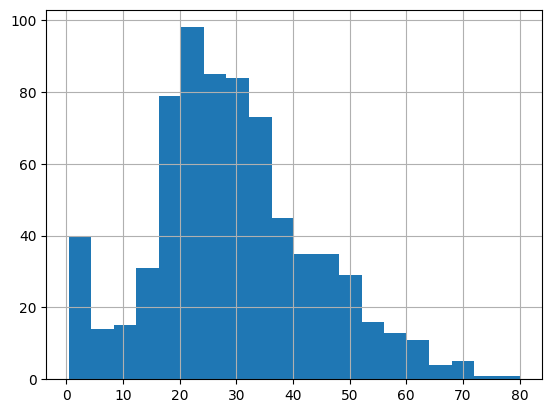

In [20]:
data["Age"].hist(bins=20);

In [21]:
age_med = data["Age"].median()
age_med

np.float64(28.0)

In [22]:
data_info["age_median"] = age_med

In [23]:
data["Age"] = data["Age"].fillna(age_med).astype("int8")

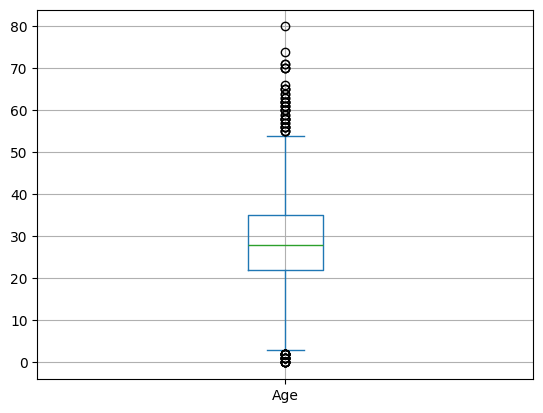

In [24]:
data.Age.plot.box()
plt.grid()

In [25]:
data.SibSp.value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [26]:
data.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [27]:
data_info["SibSp"] = data.SibSp.value_counts()
data_info["Parch"] = data.Parch.value_counts()

In [28]:
data["SibSp"] = data["SibSp"].astype("int8")
data["Parch"] = data["Parch"].astype("int8")

In [29]:
data.drop(["Ticket", "Cabin"], axis=1, inplace=True)

In [30]:
data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<Axes: >

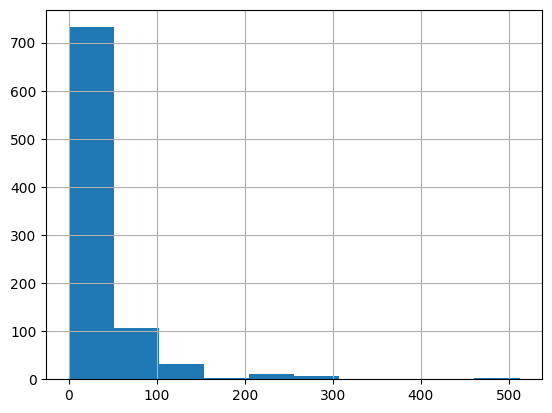

In [31]:
data.Fare.hist()

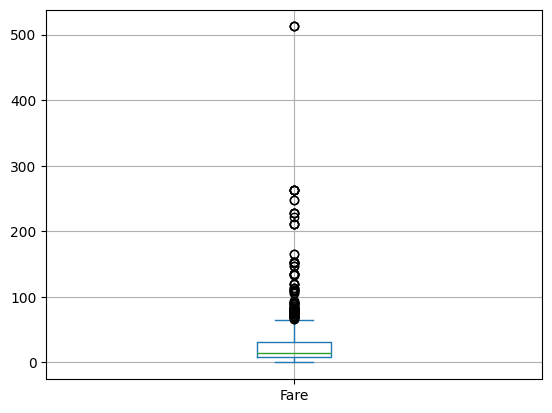

In [32]:
data.Fare.plot.box()
plt.grid()

<Axes: >

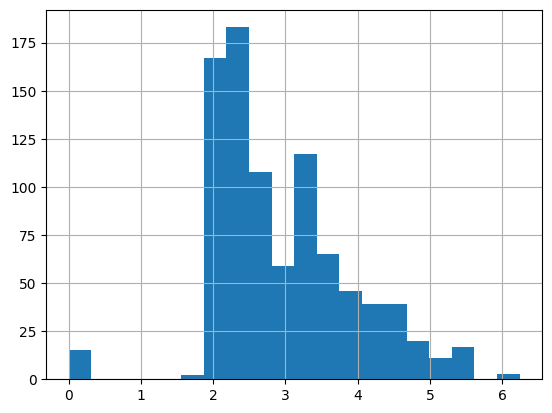

In [33]:
np.log(data.Fare + 1).hist(bins=20)

In [34]:
data["Fare"] = np.log(data.Fare + 1).astype("float32")

In [35]:
data["Embarked"].isna().sum()

np.int64(2)

In [36]:
data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [37]:
data_info["Embarked"] = data.Embarked.value_counts()

In [38]:
data["Embarked"] = data.Embarked.fillna("S")

In [39]:
# pd.get_dummies(data, columns=["Embarked"], dtype="int8")

In [40]:
d = data["Embarked"].value_counts()
d

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [41]:
for k in d.keys():
    data["Embarked_" + k] = (data["Embarked"] == k).astype("int8")
data.drop("Embarked", axis=1, inplace=True)

In [42]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0,3,1,22,1,0,2.110213,1,0,0
1,1,1,0,38,1,0,4.280593,0,1,0
2,1,3,0,26,0,0,2.188856,1,0,0
3,1,1,0,35,1,0,3.990834,1,0,0
4,0,3,1,35,0,0,2.202765,1,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,2.639057,1,0,0
887,1,1,0,19,0,0,3.433987,1,0,0
888,0,3,0,28,1,2,3.196630,1,0,0
889,1,1,1,26,0,0,3.433987,0,1,0


In [43]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int8   
 1   Pclass      891 non-null    int8   
 2   Sex         891 non-null    int8   
 3   Age         891 non-null    int8   
 4   SibSp       891 non-null    int8   
 5   Parch       891 non-null    int8   
 6   Fare        891 non-null    float32
 7   Embarked_S  891 non-null    int8   
 8   Embarked_C  891 non-null    int8   
 9   Embarked_Q  891 non-null    int8   
dtypes: float32(1), int8(9)
memory usage: 11.4 KB


In [49]:
(data - data.min()) / (data.max() - data.min())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0.0,1.0,1.0,0.2750,0.125,0.000000,0.338125,1.0,0.0,0.0
1,1.0,0.0,0.0,0.4750,0.125,0.000000,0.685892,0.0,1.0,0.0
2,1.0,1.0,0.0,0.3250,0.000,0.000000,0.350727,1.0,0.0,0.0
3,1.0,0.0,0.0,0.4375,0.125,0.000000,0.639463,1.0,0.0,0.0
4,0.0,1.0,1.0,0.4375,0.000,0.000000,0.352955,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.5,1.0,0.3375,0.000,0.000000,0.422864,1.0,0.0,0.0
887,1.0,0.0,0.0,0.2375,0.000,0.000000,0.550238,1.0,0.0,0.0
888,0.0,1.0,0.0,0.3500,0.125,0.333333,0.512205,1.0,0.0,0.0
889,1.0,0.0,1.0,0.3250,0.000,0.000000,0.550238,0.0,1.0,0.0


In [54]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int8

In [55]:
x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,3,1,22,1,0,2.110213,1,0,0
1,1,0,38,1,0,4.280593,0,1,0
2,3,0,26,0,0,2.188856,1,0,0
3,1,0,35,1,0,3.990834,1,0,0
4,3,1,35,0,0,2.202765,1,0,0
...,...,...,...,...,...,...,...,...,...
886,2,1,27,0,0,2.639057,1,0,0
887,1,0,19,0,0,3.433987,1,0,0
888,3,0,28,1,2,3.196630,1,0,0
889,1,1,26,0,0,3.433987,0,1,0
